In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
 "D:\DENTAL\DentalArc",
     shuffle = True,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
 )

Found 12320 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
class_names

['Calculus',
 'Data caries',
 'Gingivitis',
 'Mouth Ulcer',
 'Tooth Discoloration',
 'hypodontia']

In [6]:
len(dataset)

385

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 4 2 4 0 3 3 2 4 1 1 5 3 3 2 3 0 3 3 3 1 3 1 2 1 2 4 2 4 0 1 1]


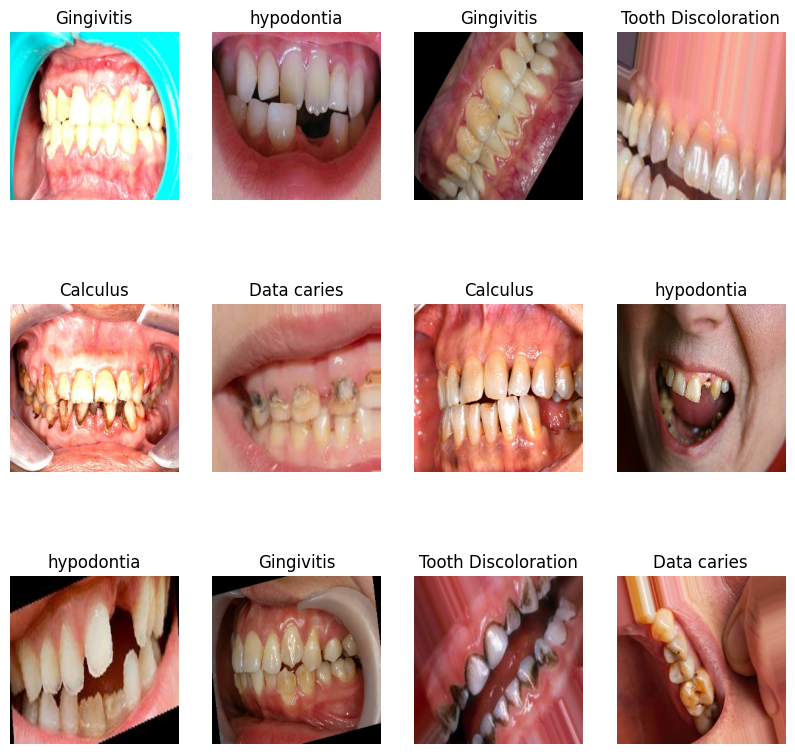

In [8]:
plt.figure(figsize =(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
    
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

308.0

In [10]:
train_ds = dataset.take(308)
len(train_ds)

308

In [11]:
test_ds = dataset.skip(308)
len(test_ds)

77

In [12]:
val_size = 0.1
len(dataset)*val_size

38.5

In [13]:
val_ds = test_ds.take(38)
len(val_ds)

38

In [14]:
test_ds = test_ds.skip(38)
len(test_ds)

39

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 69)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6
model = models.Sequential([resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), 
     layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation = 'softmax'),                       
])
                        
model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds

 )

Epoch 1/50
308/308 [==============================] - 292s 446ms/step - loss: 1.5149 - accuracy: 0.3474 - val_loss: 1.2722 - val_accuracy: 0.4646
Epoch 2/50
308/308 [==============================] - 60s 196ms/step - loss: 1.1552 - accuracy: 0.5093 - val_loss: 1.0147 - val_accuracy: 0.5699
Epoch 3/50
308/308 [==============================] - 16s 53ms/step - loss: 1.0228 - accuracy: 0.5689 - val_loss: 1.0912 - val_accuracy: 0.5263
Epoch 4/50
308/308 [==============================] - 16s 53ms/step - loss: 0.9538 - accuracy: 0.6017 - val_loss: 0.9080 - val_accuracy: 0.6160
Epoch 5/50
308/308 [==============================] - 16s 53ms/step - loss: 0.8924 - accuracy: 0.6239 - val_loss: 0.9353 - val_accuracy: 0.6160
Epoch 6/50
308/308 [==============================] - 17s 54ms/step - loss: 0.8405 - accuracy: 0.6445 - val_loss: 0.8095 - val_accuracy: 0.6604
Epoch 7/50
308/308 [==============================] - 17s 55ms/step - loss: 0.7940 - accuracy: 0.6663 - val_loss: 0.7987 - val_accura

In [24]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 1s 18ms/step - loss: 0.4137 - accuracy: 0.8446


In [25]:
scores

[0.4137054681777954, 0.8445723652839661]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 308}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

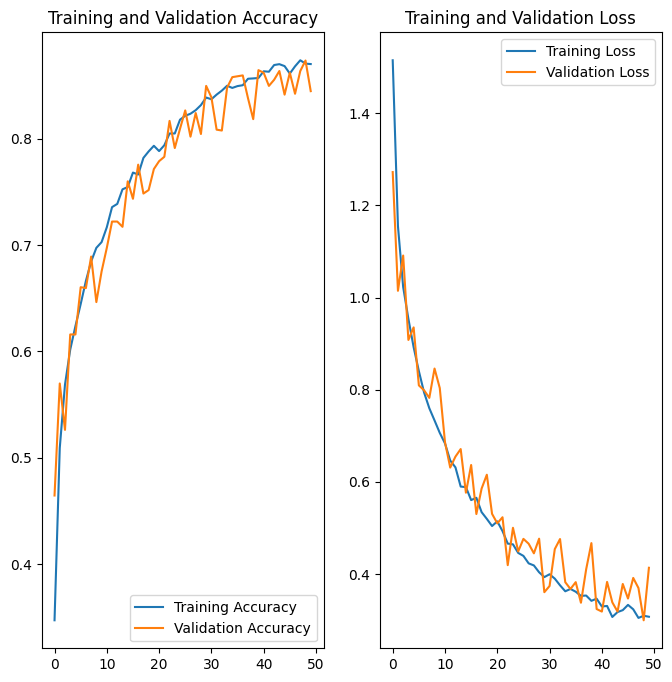

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss,label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First image to predict
Actual label Calculus
predicted Label Calculus


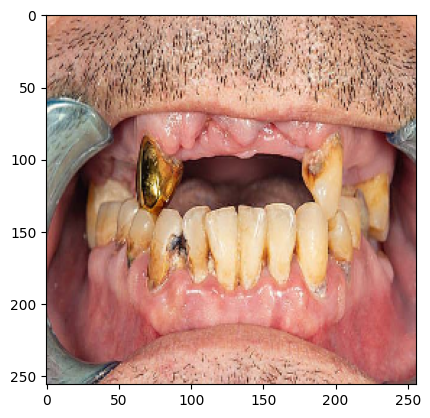

In [85]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted Label",class_names[np.argmax(batch_prediction[0])])

In [86]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

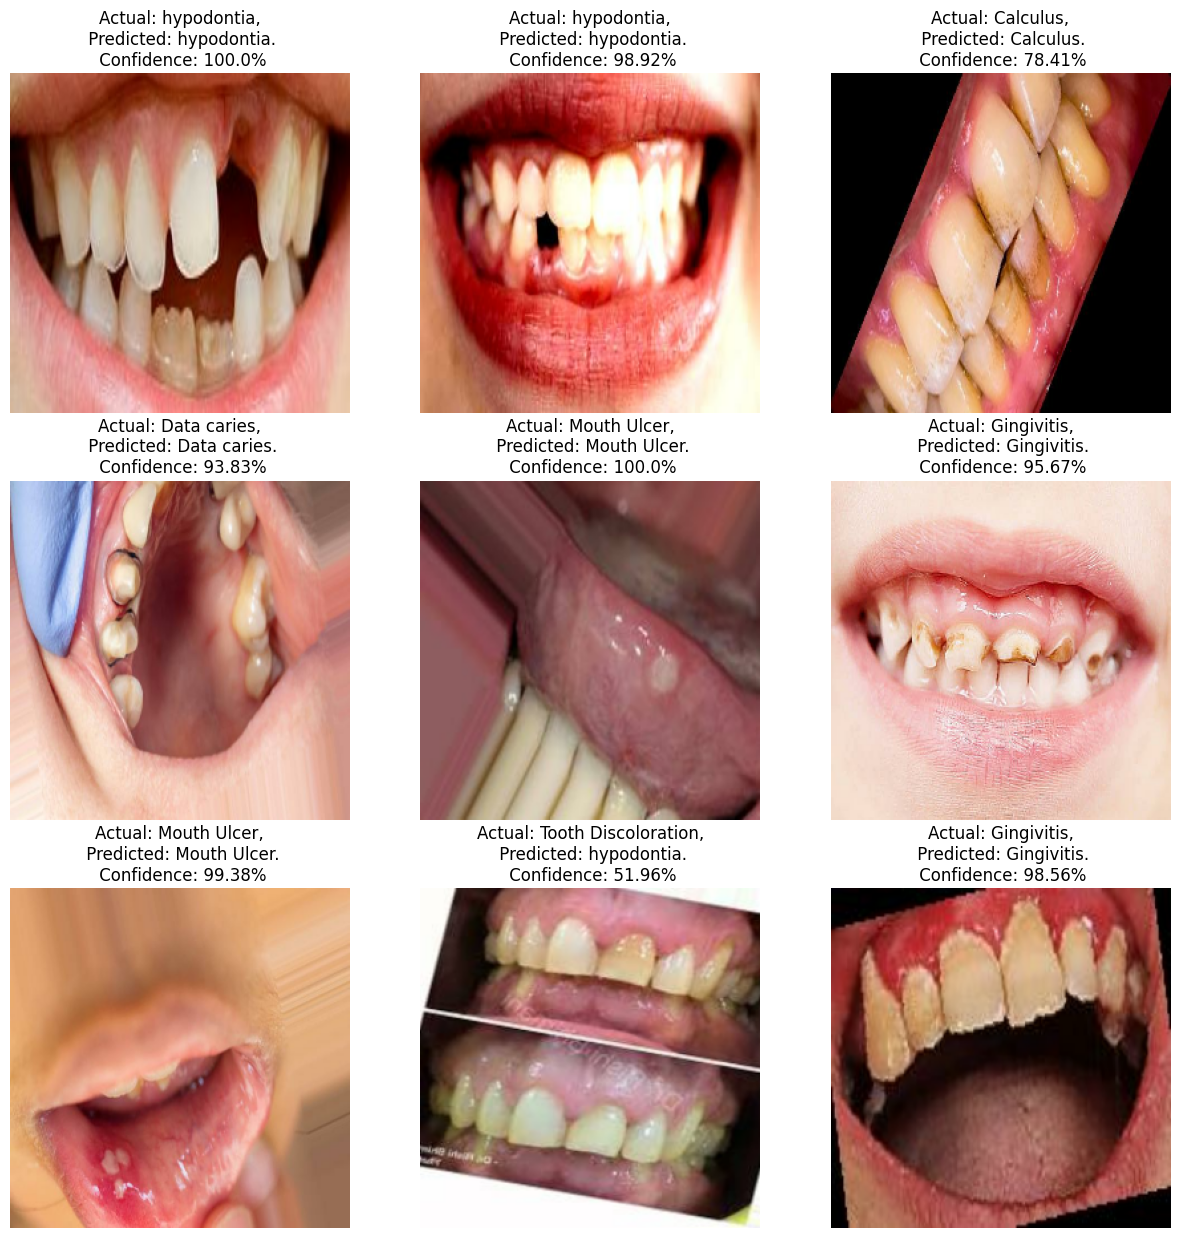

In [87]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [94]:
model.save("C:\\Users\\kiran\\Dental-Model\\Models\\1")  

INFO:tensorflow:Assets written to: C:\Users\kiran\Dental-Model\Models\1\assets


In [95]:
model.save("C:\\Users\\kiran\\Dental-Model\\Models\\dixiV1.h5")  